In [40]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import datetime
from keras import backend as K
from keras.initializers import glorot_normal
from keras.layers import Layer
from keras.layers import Input, Dense
from keras.models import Model
from keras.layers import LSTM
import logging
import psycopg2 as pg
import pandas.io.sql as psql
import math

In [41]:
from temp_mosum.mosum_library import mosum_function

In [42]:
from abc import ABC
class Dataset(ABC):
    def __init__(self):
        super().__init__()

    def next_batch(self, **kwargs):
        pass

class NNModel(ABC):
    def __init__(self):
        super().__init__()

    def net_structure(self, **kwargs):
        pass

    def instantiate_and_fit(self, **kwargs):
        pass  

In [43]:
def ts_generator(ts_obj, n_steps):
    while 1:
        batch = ts_obj.next_batch(1, n_steps)
        yield batch[0], batch[1]

In [44]:
dataframe=pd.read_csv('Dataset1.csv', delimiter=',')
dataframe = dataframe.fillna(value=np.nan)               
all_features = dataframe.columns[2:].values    
def statistics(dataframe, feature):
    zeros = 0
    for el in dataframe[feature].values:
        if math.isnan(el) or el == None:
            zeros += 1
    return zeros/len( dataframe[feature].values)

In [45]:
data=dataframe
dataframe.index=dataframe['date']
dataframe.drop("date",inplace=True, axis=1)
dataframe=dataframe['values']

In [46]:
result = mosum_function.mosum(dataframe, G=20, criterion = 'eta')
cpts_list = result['cpts']

In [47]:
print(cpts_list)

[8, 31, 65, 99, 119, 133, 198]


In [48]:
import tensorflow as tf
import math
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

def gaussian_likelihood(sigma):
    def gaussian_loss(y_true, y_pred):
        result = keras.losses.mean_squared_error(y_true, y_pred)
        result = K.print_tensor(result, message='losses')
        print(result)
        return tf.math.reduce_mean(0.5*tf.math.log(sigma) + 0.5*tf.divide(tf.math.square(y_true - y_pred), sigma)) + 1e-6 + 6
    return gaussian_loss

In [49]:
test = data.loc[:, "values"]
test1 = test.values
source_df = pd.DataFrame({'feature_1': test1[:-1], 'target': test1[1:]})
source_df['category'] = ['1' for i in range(source_df.shape[0])]
i=2
for name, values in data.iteritems():
    featurename = 'feature_' + str(i)
    source_df[featurename] = data[name].values[1:]
    i +=1

def put_target_last_place(data):
    data = data.rename(columns={"category": "category_"})
    data.insert(loc=1, column='category', value=data['category_'].values)
    data = data.drop(columns=["category_"])
    return data
source_df = put_target_last_place(source_df)

size = int(len(source_df) * 0.60)
training = source_df.iloc[0:size]
test= source_df.iloc[size: len(source_df)]

In [53]:
diff_list = [x - cpts_list[i - 1] for i, x in enumerate(cpts_list)][1:]
diff_list.sort()
batch_size=diff_list[0] // 2  

In [54]:
epochs=200
steps_per_epoch=10
variant_count=2
batch_size=batch_size

In [55]:
class GaussianLayer(Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        self.kernel_1, self.kernel_2, self.bias_1, self.bias_2 = [], [], [], []
        super(GaussianLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        n_weight_rows = input_shape[2]
        self.kernel_1 = self.add_weight(name='kernel_1',
                                        shape=(n_weight_rows, self.output_dim),
                                        initializer=glorot_normal(),
                                        trainable=True)
        self.kernel_2 = self.add_weight(name='kernel_2',
                                        shape=(n_weight_rows, self.output_dim),
                                        initializer=glorot_normal(),
                                        trainable=True)
        self.bias_1 = self.add_weight(name='bias_1',
                                      shape=(self.output_dim,),
                                      initializer=glorot_normal(),
                                      trainable=True)
        self.bias_2 = self.add_weight(name='bias_2',
                                      shape=(self.output_dim,),
                                      initializer=glorot_normal(),
                                      trainable=True)
        super(GaussianLayer, self).build(input_shape)
    def call(self, x):
        output_mu = K.dot(x, self.kernel_1) + self.bias_1
        output_sig = K.dot(x, self.kernel_2) + self.bias_2
        output_sig_pos = K.log(1 + K.exp(output_sig)) + 1e-06
        return [output_mu, output_sig_pos]
    def compute_output_shape(self, input_shape):
        return [(input_shape[0], self.output_dim), (input_shape[0], self.output_dim)]

In [57]:
class DeepArTrainingInfo(): 
    def __init__(self, epoch, batch, loss, hasChangepoint):
        self.__epoch = epoch
        self.__batch = batch
        self.__loss = loss
        self.__hasChangepoint = hasChangepoint

    def get_epoch(self):
        return self.__epoch

    def get_batch(self):
        return self.__batch

    def get_loss(self):
        return self.__loss

    def get_hasChangepoint(self):
        return self.__hasChangepoint


    def set_epoch(self, x):
        self.__epoch = x

    def set_batch(self, x):
        self.__batch = x

    def set_loss(self, x):
        self.__loss = x

    def set_hasChangepoint(self, x):
        self.__hasChangepoint = x

In [58]:
keras = tf.keras
logger = logging.getLogger('deepar')

def examine_loss(y_true, y_pred):
        result = keras.losses.mean_squared_error(y_true, y_pred)
        result = K.print_tensor(y_true, message='losses----->')
        return result

class DeepAR(NNModel):
    def __init__(self, ts_obj, steps_per_epoch=steps_per_epoch, epochs=epochs, loss=gaussian_likelihood,
                 optimizer='adam', with_custom_nn_structure=None):
        self.ts_obj = ts_obj
        self.inputs, self.z_sample = None, None
        self.steps_per_epoch = steps_per_epoch
        self.epochs = epochs
        self.loss = loss
        self.optimizer = optimizer
        self.keras_model = None
        if with_custom_nn_structure:
            self.nn_structure = with_custom_nn_structure
        else:
            self.nn_structure = DeepAR.basic_structure
        self._output_layer_name = 'main_output'
        self.get_intermediate = None
    @staticmethod
    def basic_structure():
        input_shape = (batch_size, variant_count)
        inputs = Input(shape=input_shape)
        x = LSTM(30, return_sequences=True)(inputs)
        x = Dense(3, activation='relu')(x)
        loc, scale = GaussianLayer(1, name='main_output')(x)
        return input_shape, inputs, [loc, scale]
    
    def instantiate_and_fit(self, verbose=False):
        input_shape, inputs, theta = self.nn_structure()
        print(input_shape)
        model = Model(inputs, theta[0])

        def examine_loss(y_true, y_pred):
            result = keras.losses.mean_squared_error(y_true, y_pred)
            result = K.print_tensor(result, message='losses----->')
            return result

        model.compile(loss=self.loss(theta[1]), optimizer=self.optimizer)
        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

        model.fit(ts_generator(self.ts_obj,
                                         input_shape[0]),
                            steps_per_epoch=self.steps_per_epoch,
                            epochs=self.epochs,callbacks=[tensorboard_callback, kerasCallback])
        if verbose:
            logger.debug('Model was successfully trained')
        self.keras_model = model
        self.get_intermediate = K.function(inputs=[self.model.input],
                                           outputs=self.model.get_layer(self._output_layer_name).output)
        
        model.summary()
    @property
    def model(self):
        return self.keras_model
    def predict_theta_from_input(self, input_list):
        if not self.get_intermediate:
            raise ValueError('TF model must be trained first!')
        return self.get_intermediate(input_list)


In [60]:
filter_change_point = ''
batch_count = int(len(training)/batch_size)
change_points_found_in_training = []
current_epoch = 0
deepArTrainingInfos = []

while True:
    filter_change_point = str(input('Apply change point filter? True / False: ') or "True")
    filter_change_point = filter_change_point.capitalize()
    if filter_change_point.capitalize() == 'True':
        print('Filter = ' + filter_change_point)
        break
    elif filter_change_point.capitalize() == 'False':
        print('Filter = ' + filter_change_point)
        break

    else:
        print('Enter True or False')
        continue


class KerasCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.__current_epoch = 0
        self.__start_index = 0
        self.__end_index= 0
        self.__loss_per_batch = []
        self.__hasChangePoint = False
        self.__df_deepar_infos = pd.DataFrame(columns=['key','Epoch', 'Batch', 'Loss', 'hasChangepoint','start','end'])

    def set_start_index(self, index):
        self.__start_index = index

    def set_end_index(self, index):
        self.__end_index = index

    def get_df_deepar_infos(self):
        return self.__df_deepar_infos

    def set_hasChangePoint(self, hasChangepoint):
        self.__hasChangePoint = hasChangepoint   

    def get_hasChangepoint(self):
        return self.__hasChangePoint

    def get_current_epoch(self):
        return self.__current_epoch
         
    def get_loss_per_batch(self):
        return self.__loss_per_batch

    def on_epoch_begin(self, epoch, logs=None):
        self.__current_epoch = epoch

    def on_predict_end(self, logs):
        print(logs)    

    
    def on_train_batch_end(self, batch, logs=None): 
        print(logs)
        self.__loss_per_batch.append(DeepArTrainingInfo(epoch =self.__current_epoch,batch=batch,loss=logs['loss'], hasChangepoint= self.__hasChangePoint))
        temp_df = pd.DataFrame([[str(self.__current_epoch) + ":" + str(batch), self.__current_epoch, batch,logs['loss'], self.__hasChangePoint, self.__start_index, self.__end_index]]
                               ,columns=['key','Epoch', 'Batch', 'Loss', 'hasChangepoint','start','end'])
        self.__df_deepar_infos = pd.concat([self.__df_deepar_infos, temp_df], axis=0, ignore_index=True)


kerasCallback = KerasCallback()

class TimeSeries(Dataset):
    def __init__(self, pandas_df, one_hot_root_list=None, grouping_variable='category', scaler=None):
        super().__init__()
        self.data = pandas_df
        self.one_hot_root_list = one_hot_root_list
        self.grouping_variable = grouping_variable
        self.current_batch_nr = 0
        if self.data is None:
            raise ValueError('Must provide a Pandas df to instantiate this class')
        self.scaler = scaler
    def _one_hot_padding(self, pandas_df, padding_df):
        for one_hot_root in self.one_hot_root_list:
            one_hot_columns = [i for i in pandas_df.columns 
                               if i.startswith(one_hot_root) and pandas_df[i].values[0] == 1]
            for col in one_hot_columns:
                padding_df[col] = 1
        return padding_df
    def _pad_ts(self, pandas_df, desired_len, padding_val=0):
        pad_length = desired_len - pandas_df.shape[0]
        padding_df = pd.concat([pd.DataFrame({col: padding_val for col in pandas_df.columns},
                                             index=[i for i in range(pad_length)])])
        if self.one_hot_root_list:
            padding_df = self._one_hot_padding(pandas_df, padding_df)
        return pd.concat([padding_df, pandas_df]).reset_index(drop=True)
    
    @staticmethod
    def logChangepoint(params, model):
        return tf.keras.callbacks.Callback()
        print("in callback")

    @staticmethod 
    def _has_changepoint_in_index(start_index, end_index, batch_number):
        has_change_point = False
        for cpv in cpts_list:
            if (cpv >= start_index and cpv <= end_index):
                change_points_found_in_training.append((cpv,batch_number, kerasCallback.get_current_epoch()))
                print('Found change point: ' + str(cpv) + ' in batch ' + str(batch_number) + ' with index :'+ str(start_index)+ ' and ' +str(end_index) )  
                has_change_point = True
                break
            return has_change_point
           
    @staticmethod
    def _find_valid_index(pandas_df, desired_len, batch_number):
        start_index = 0
        end_index = 0
        valid_index = False

        if filter_change_point == 'False':
            start_index = np.random.choice([i for i in range(0, pandas_df.shape[0] - desired_len + 1)])
            end_index = start_index + desired_len
            has_changePoint = TimeSeries._has_changepoint_in_index(start_index, end_index, batch_number)
            kerasCallback.set_hasChangePoint(has_changePoint)
        else:  
            while valid_index == False:
                start_index = np.random.choice([i for i in range(0, pandas_df.shape[0] - desired_len + 1)])
                end_index = start_index + desired_len
                valid_index = not TimeSeries._has_changepoint_in_index(start_index, end_index, batch_number)
        
        kerasCallback.set_end_index(end_index)
        kerasCallback.set_start_index(start_index)
        return start_index, end_index       
                
    @staticmethod
    def _sample_ts(pandas_df, desired_len, batch_number):
        if pandas_df.shape[0] < desired_len:
            raise ValueError('Desired sample length is greater than df row len')
        if pandas_df.shape[0] == desired_len:
            return pandas_df
        start_index, end_index = TimeSeries._find_valid_index(pandas_df, desired_len, batch_number)

        return pandas_df.iloc[start_index: end_index, ]
    def next_batch(self, batch_size, n_steps,
                   target_var='target', verbose=False,
                   padding_value=0):
        if self.current_batch_nr % steps_per_epoch == 0:
            self.current_batch_nr = 1
        else:
            self.current_batch_nr = self.current_batch_nr + 1

        groups_list = self.data[self.grouping_variable].unique()
        np.random.shuffle(groups_list)
        selected_groups = groups_list[:batch_size]
        input_data = self.data[self.data[self.grouping_variable].isin(set(selected_groups))]
        sampled = []
        print("step ......", batch_size, n_steps)
        for cat, cat_data in input_data.groupby(self.grouping_variable):
                
                if cat_data.shape[0] < n_steps:
                    sampled_cat_data = self._pad_ts(pandas_df=cat_data,
                                                    desired_len=n_steps,
                                                    padding_val=padding_value)
                else:
                    sampled_cat_data = self._sample_ts(pandas_df=cat_data,
                                                       desired_len=n_steps,
                                                       batch_number=self.current_batch_nr)
                sampled.append(sampled_cat_data)
        rnn_output = pd.concat(sampled).drop(columns=self.grouping_variable).reset_index(drop=True)
        if self.scaler:
            batch_scaler = self.scaler()
            n_rows = rnn_output.shape[0]
            for i in range(1,variant_count):
                featurename = "feature_" + str(i)
                rnn_output[featurename] = rnn_output[featurename].astype('float')           
                rnn_output[featurename] = batch_scaler.fit_transform(rnn_output[featurename].values.reshape(n_rows, 1)).reshape(n_rows)
                rnn_output[target_var] = rnn_output[target_var].astype('float')
                rnn_output[target_var] = batch_scaler.fit_transform(rnn_output[target_var].values.reshape(n_rows, 1)).reshape(n_rows)
        return rnn_output.drop(target_var, 1).values.reshape(batch_size, n_steps, -1), \
               rnn_output[target_var].values.reshape(batch_size, n_steps, 1)

Apply change point filter? True / False:  true


Filter = True


In [61]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler
ts_train = TimeSeries(training, scaler=MinMaxScaler)
ts_test = TimeSeries(test, scaler=MinMaxScaler)
dp_model = DeepAR(ts_train, epochs=epochs)
dp_model.instantiate_and_fit()

(7, 2)
Tensor("loss/main_output_loss/Identity:0", shape=(None, 7), dtype=float32)
step ...... 1 7
step ...... 1 7
step ...... 1 7
step ...... 1 7
step ...... 1 7
step ...... 1 7
Found change point: 8 in batch 6 with index :8 and 15
step ...... 1 7
step ...... 1 7
step ...... 1 7
step ...... 1 7
step ...... 1 7
Epoch 1/200
step ...... 1 7
{'batch': 0, 'size': 1, 'loss': 7.036661}
 1/10 [==>...........................] - ETA: 22s - batch: 0.0000e+00 - size: 1.0000 - loss: 7.0367step ...... 1 7
{'batch': 1, 'size': 1, 'loss': 7.1696005}
 2/10 [=====>........................] - ETA: 0s - batch: 0.5000 - size: 1.0000 - loss: 7.1031     step ...... {'batch': 2, 'size': 1, 'loss': 7.088808}
1 7
{'batch': 3, 'size': 1, 'loss': 6.9104037}
step ...... 1 7
step ...... 1 {'batch': 4, 'size': 1, 'loss': 6.7492814}
7
 5/10 [==============>...............] - ETA: 0s - batch: 2.0000 - size: 1.0000 - loss: 6.9910step ...... 1 7
{'batch': 5, 'size': 1, 'loss': 7.0590296}
step ...... 1 7
{'batch': 6, 'si

step ...... 1 7


100%|██████████| 3/3 [00:00<00:00, 263.69it/s]


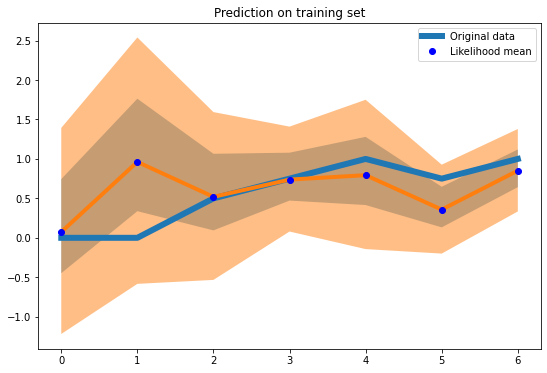

In [65]:
%matplotlib inline
from numpy.random import normal
import tqdm
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
batch = ts_train.next_batch(1,batch_size)
def get_sample_prediction(sample, fn, n_steps=batch_size):
    sample = np.array(sample).reshape(1, n_steps, variant_count)
    output = fn([sample])
    samples = []
    for mu, sigma in zip(output[0].reshape(n_steps), output[1].reshape(n_steps)):
        samples.append(normal(loc=mu, scale=np.sqrt(sigma), size=1)[0])
    return np.array(samples)
ress = []
for i in tqdm.tqdm(range(3)):
    pred = get_sample_prediction(batch[0], dp_model.predict_theta_from_input)
    ress.append(pred)
def plot_uncertainty(ress, ground_truth, n_steps=batch_size, figsize=(9, 6), 
                     prediction_dots=True, title='Prediction on training set'):
    
    res_df = pd.DataFrame(ress).T
    tot_res = res_df
    plt.figure(figsize=figsize)
    plt.plot(ground_truth.reshape(n_steps), linewidth=6, label='Original data')
    tot_res['mu'] = tot_res.apply(lambda x: np.mean(x), axis=1)
    tot_res['upper'] = tot_res.apply(lambda x: np.mean(x) + np.std(x), axis=1)
    tot_res['lower'] = tot_res.apply(lambda x: np.mean(x) - np.std(x), axis=1)
    tot_res['two_upper'] = tot_res.apply(lambda x: np.mean(x) + 2*np.std(x), axis=1)
    tot_res['two_lower'] = tot_res.apply(lambda x: np.mean(x) - 2*np.std(x), axis=1)
    plt.plot(tot_res.mu, linewidth=4)
    if prediction_dots:
        plt.plot(tot_res.mu, 'bo', label='Likelihood mean')
    plt.fill_between(x = tot_res.index, y1=tot_res.lower, y2=tot_res.upper, alpha=0.5)
    plt.fill_between(x = tot_res.index, y1=tot_res.two_lower, y2=tot_res.two_upper, alpha=0.5)
    plt.title(title)
    plt.legend()
    
plot_uncertainty(ress, batch[1])

step ...... 1 7
(1, 7, 1)


100%|██████████| 300/300 [00:00<00:00, 387.61it/s]


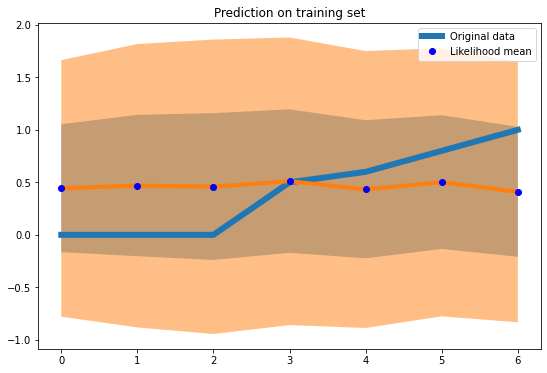

In [69]:
from sklearn.preprocessing import MinMaxScaler

batch = ts_train.next_batch(1, batch_size)
print(batch[1].shape)
def get_prediction(sample, prediction_fn):
    sample = np.array(sample).reshape(1, batch_size, variant_count)
    output = prediction_fn([sample])
    samples = []
    for mu, sigma in zip(output[0].reshape(batch_size), output[0].reshape(batch_size)):
        samples.append(normal(loc=mu, scale = np.sqrt(sigma), size=1)[0])
    return np.array(samples)
res = []
for i in tqdm.tqdm(range(300)):
    pred = get_prediction(batch[0], dp_model.predict_theta_from_input)
    res.append(pred)
plot_uncertainty(res, batch[1]) 

In [70]:
features= []
for i in range(1, variant_count+1):
    features.append("feature_" + str(i))
test_feat = test[features]

In [115]:
train_variable=15
test_variable=15

In [116]:
train_feat =training[features][:-train_variable]
values_train = train_feat.values
values = test_feat.values[:test_variable]

In [117]:
curr = 0
batches_train= []
for i in range(batch_size, len(dataframe) , batch_size):
    batch = values_train[curr:i]
    batches_train.append(batch)
    curr = i

In [118]:
curr = 0
batches_test= []
for i in range(batch_size, test_variable, batch_size):
    batch = values[curr:i]
    batches_test.append(batch)
    curr = i

In [119]:
test_target_values = test.target.values
train_target_values =training.target.values[:-train_variable]

In [120]:
curr = 0
batch_targets_train = []
for i in range(batch_size, len(dataframe) , batch_size):
    batch = train_target_values[curr:i]
    batch_targets_train.append(batch)
    curr = i

In [121]:
curr = 0
batch_targets_test = []
for i in range(batch_size, test_variable, batch_size):
    batch = test_target_values[curr:i]
    batch_targets_test.append(batch)
    curr = i

In [99]:
predictions_train = []
for batch in batches_train:
    if batch.size ==batch_size*2:
        scaler = MinMaxScaler()
        scaled_batch = scaler.fit_transform(batch.reshape(batch_size,variant_count))
        scaler_min, scaler_scale, scaler_data_min, scaler_data_max= scaler.min_, scaler.scale_, scaler.data_min_, scaler.data_max_

        unscaled_prediction = get_sample_prediction(scaled_batch, dp_model.predict_theta_from_input)
        scaler1 = MinMaxScaler()
        scaler1.min_, scaler1.scale_ = scaler_min[0], scaler_scale[0]
        ress.append(scaler1.inverse_transform([unscaled_prediction])[0])
        predictions_train.append(scaler1.inverse_transform([unscaled_prediction])[0])

In [100]:
predictions_train= np.concatenate( predictions_train, axis=0 )
batch_targets_train= np.concatenate( batch_targets_train, axis=0 )

In [113]:
from sklearn.metrics import mean_squared_error 
trainScore = math.sqrt(mean_squared_error(batch_targets_train, predictions_train)) 
print('Train Score: %.2f RMSE' % (trainScore)) 

Train Score: 8.20 RMSE


In [122]:
predictions_test = []
for batch in batches_test:
    if batch.size ==batch_size*2:
        scaler = MinMaxScaler()
        scaled_batch = scaler.fit_transform(batch.reshape(batch_size, variant_count))
        scaler_min, scaler_scale, scaler_data_min, scaler_data_max= scaler.min_, scaler.scale_, scaler.data_min_, scaler.data_max_

        unscaled_prediction = get_sample_prediction(scaled_batch, dp_model.predict_theta_from_input)
        scaler1 = MinMaxScaler()
        scaler1.min_, scaler1.scale_ = scaler_min[0], scaler_scale[0]
        ress.append(scaler1.inverse_transform([unscaled_prediction])[0])
        predictions_test.append(scaler1.inverse_transform([unscaled_prediction])[0])

In [123]:
predictions_test= np.concatenate( predictions_test, axis=0 )
batch_targets_test= np.concatenate( batch_targets_test, axis=0 )

In [124]:
from sklearn.metrics import mean_squared_error
testScore = math.sqrt(mean_squared_error(batch_targets_test, predictions_test))
print('Test Score: %.2f RMSE' % (testScore)) 

Test Score: 14.89 RMSE
